### Mission 2 : Modélisation et tracking des expériences
- **Objectif** : Construire un modèle de régression et suivre les expériences avec MLflow.
- **Tâches** :
  1. Créer un modèle de régression linéaire comme baseline.
  2. Utiliser des modèles avancés comme Random Forest ou Gradient Boosting.
  3. Mettre en place MLflow pour suivre les expériences (métriques comme RMSE, MAE, R²).
  4. Enregistrer le meilleur modèle dans le *Model Registry* de MLflow.

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn

# Load the cleaned dataset
df = pd.read_csv("cleaned_california_housing.csv")

# Split the dataset
X = df.drop(columns="MedHouseVal")
y = df["MedHouseVal"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape}")
print(f"Testing data size: {X_test.shape}")


Training data size: (13049, 8)
Testing data size: (3263, 8)


In [2]:
from mlflow.models import infer_signature
from sklearn.ensemble import GradientBoostingRegressor

mlflow.end_run()

mlflow.set_experiment("california_housing")


def evaluate_and_log_model(model, model_name, params):
    with mlflow.start_run(run_name=f"Run_{model_name}"):
        # Log model parameters
        mlflow.log_params(params)

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Log the model with signature
        signature = infer_signature(X_test, y_pred)
        mlflow.sklearn.log_model(model, model_name, signature=signature, input_example=X_test.head())

        # Add a tag to the run
        mlflow.set_tag("model_type", model_name)

        print(f"Model: {model_name}\n  RMSE: {rmse}\n  MAE: {mae}\n  R2: {r2}\n")

# Baseline: Linear Regression
lr_params = {"fit_intercept": True}
lr_model = LinearRegression(**lr_params)
evaluate_and_log_model(lr_model, "LinearRegression", lr_params)

# Advanced Model: Random Forest
rf_params = {"n_estimators": 400, "max_depth": None, "random_state": 42}
rf_model = RandomForestRegressor(**rf_params)
evaluate_and_log_model(rf_model, "RandomForest", rf_params)

# Advanced Model: Gradient Boosting
gb_params = {"n_estimators": 400, "learning_rate": 0.1, "max_depth": 3, "random_state": 42}
gb_model = GradientBoostingRegressor(**gb_params)
evaluate_and_log_model(gb_model, "GradientBoosting", gb_params)

2025/01/16 18:52:54 INFO mlflow.tracking.fluent: Experiment with name 'california_housing' does not exist. Creating a new experiment.


Model: LinearRegression
  RMSE: 0.5626031257062546
  MAE: 0.4235527429735988
  R2: 0.6378964374821559

Model: RandomForest
  RMSE: 0.42001210947416695
  MAE: 0.28819717859331895
  R2: 0.7981856052027696

Model: GradientBoosting
  RMSE: 0.40632390755554015
  MAE: 0.2814835089231425
  R2: 0.8111255255117784



In [3]:
# Register the best model manually for now
best_model = gb_model
best_model_name = "BestModel"
with mlflow.start_run(run_name=f"Register_{best_model_name}"):
    signature = infer_signature(X_test, best_model.predict(X_test))
    model_uri = mlflow.sklearn.log_model(best_model, best_model_name, signature=signature, input_example=X_test.head(), registered_model_name=best_model_name)
    print(f"Model {best_model_name} registered successfully.")


Model BestModel registered successfully.


Successfully registered model 'BestModel'.
Created version '1' of model 'BestModel'.


### Mission 3 : Analyse des features
- **Objectif** : Comprendre l’impact des variables sur les prédictions.
- **Tâches** :
  1. Calculer les importances globales des features (à l’aide de SHAP ou des features importances).
  2. Analyser l’impact local pour des exemples individuels (à l’aide de SHAP).
  3. Documenter vos conclusions.

---

Global Feature Importances for GradientBoosting:
       Feature  Importance
0      MedInc    0.464314
7   Longitude    0.175745
6    Latitude    0.152244
5    AveOccup    0.123138
2    AveRooms    0.036590
1    HouseAge    0.032287
4  Population    0.008960
3   AveBedrms    0.006721


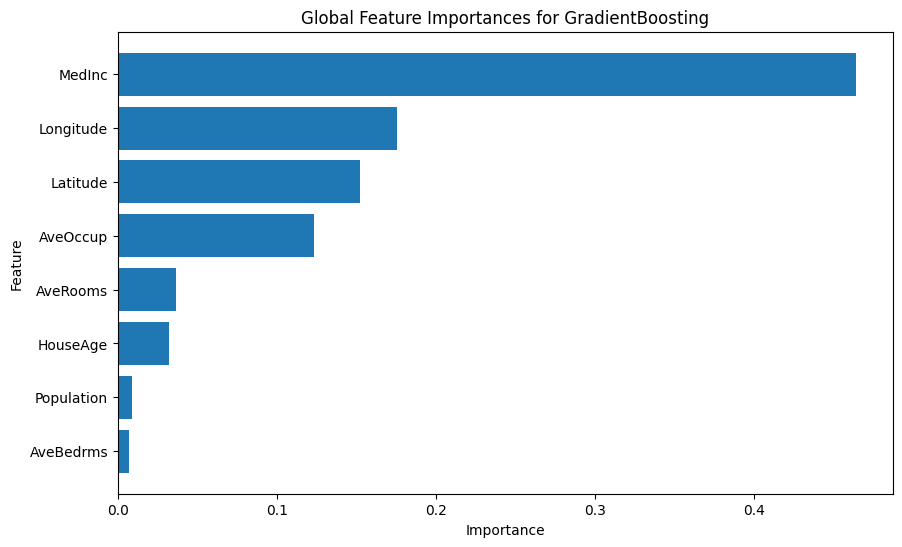

 93%|=================== | 3050/3263 [00:11<00:00]       

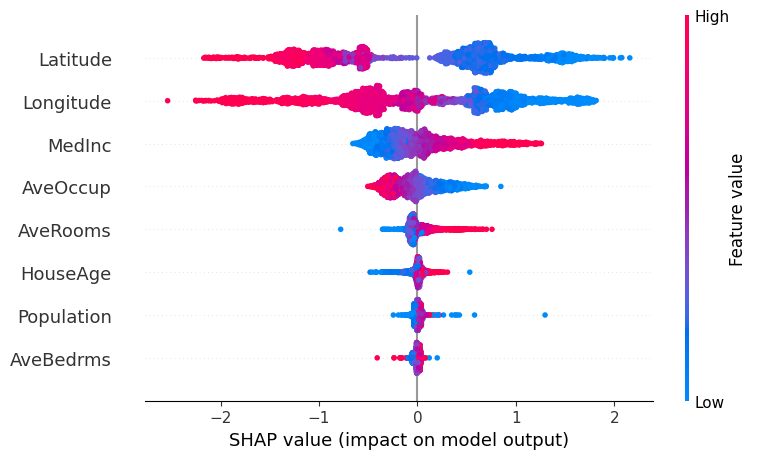

SHAP analysis for example 0:



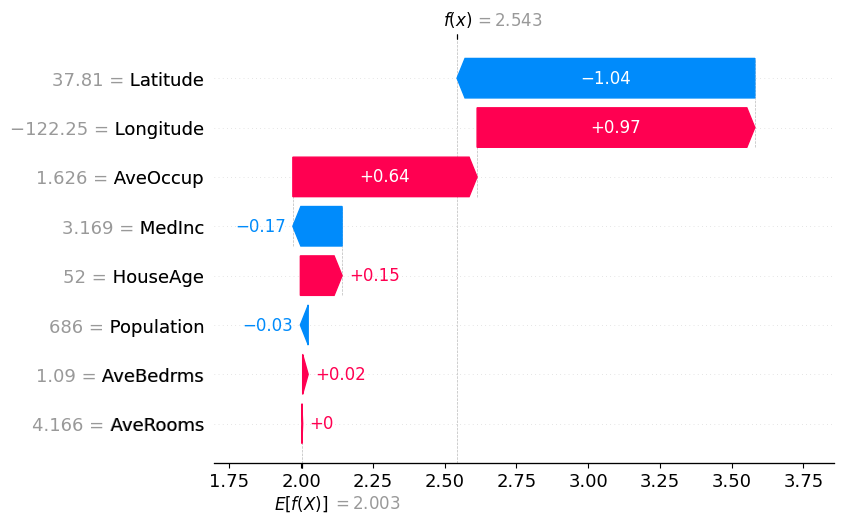

SHAP analysis for example 1:



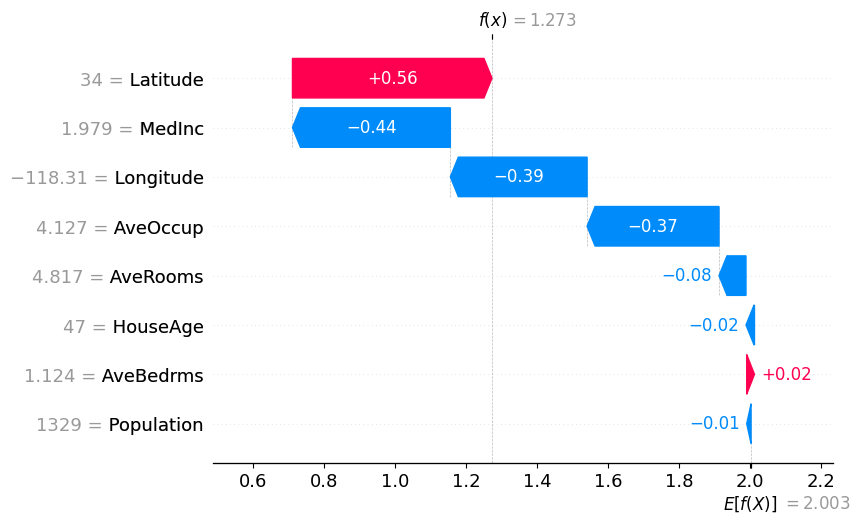

SHAP analysis for example 2:



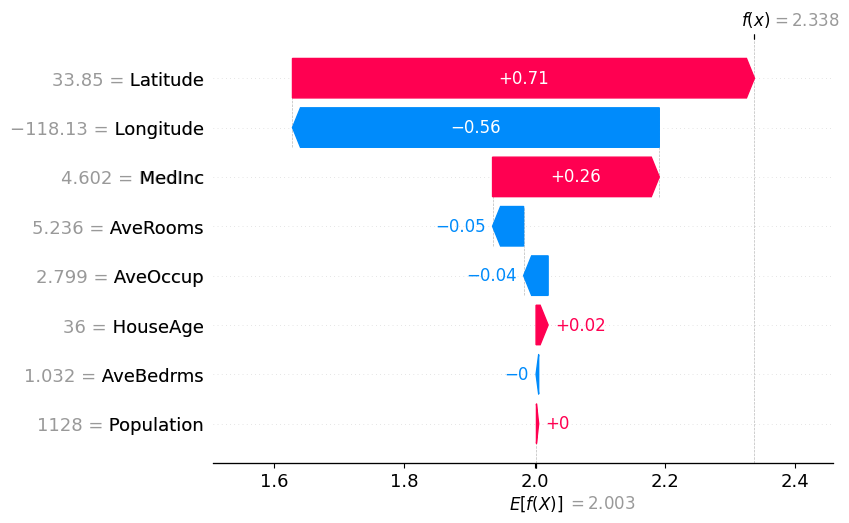

In [4]:
import shap
import matplotlib.pyplot as plt

# Feature importance analysis
def feature_importance_analysis(model, model_name):
    # Calculate global feature importances
    if hasattr(model, "feature_importances_"):
        feature_importances = model.feature_importances_
        importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
        importance_df.sort_values(by="Importance", ascending=False, inplace=True)
        print(f"Global Feature Importances for {model_name}:\n", importance_df)

        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.barh(importance_df["Feature"], importance_df["Importance"])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"Global Feature Importances for {model_name}")
        plt.gca().invert_yaxis()
        plt.show()

    # SHAP analysis with additivity check disabled
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(np.array(X_test),check_additivity=False)

    # Summary plot
    shap.summary_plot(shap_values, X_test, show=True)

    # Local example analysis
    for i in range(3):  # Analyze 3 individual examples
        print(f"SHAP analysis for example {i}:\n")
        shap.waterfall_plot(shap.Explanation(values=shap_values.values[i], base_values=shap_values.base_values[i], data=X_test.iloc[i]))


# Perform feature importance analysis for the best model
feature_importance_analysis(gb_model, "GradientBoosting")